In [1]:
import random
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import pandas as pd
import math
import seaborn as sns

# Import de la base et création du réseau

In [2]:
df = pd.read_stata('TRADHIST_v4.dta')

In [25]:
#On filtre la période 1962-1975
df["year"] = df["year"].apply(int)
df = df[df['year'].isin(range(1962, 1976))]

#On filtre les lignes qui indiquent bien des pays d'arrivée et de départ
print(["Nombres de lignes", len(df)])
print(["Valeurs manquantes pour pays de départ", sum(df["iso_o"] == "")])
print(["Valeurs manquantes pour pays d'arrivée", sum(df["iso_d"] == "")])

df = df[df["iso_d"] != ""]
df = df[df["iso_o"] != ""]
print(["Nombres de lignes", len(df)])

#On filtre les fluxs pour ne retenir que ceux pour lesquels le flow est renseigné
print(["Valeurs manquantes pour le flux", sum(df["FLOW"].isna())])
df = df[df["FLOW"].isna() == False]
df = df[df["FLOW"] != 0]
print(["Nombres de lignes base définitive", len(df)])

['Nombres de lignes', 126435]
['Valeurs manquantes pour pays de départ', 0]
["Valeurs manquantes pour pays d'arrivée", 0]
['Nombres de lignes', 126435]
['Valeurs manquantes pour le flux', 0]
['Nombres de lignes', 126435]


#### Système de pondération n°1

In [26]:
#On crée un network par an 
liste_networks = []
for year in tqdm.tqdm(range(1962, 1976)):
    locals()["group"+ str(year)] = df[df["year"] == year]
    locals()["net"+ str(year)] = nx.from_pandas_edgelist(locals()["group"+ str(year)], 'iso_o', 'iso_d', edge_attr= 'FLOW')
    liste_networks.append(locals()["net"+ str(year)])

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 17.77it/s]


#### Système de pondération n°2

In [27]:
print(df[["FLOW", "GDP_o"]].describe())

#On filtre les fluxs pour ne retenir que ceux pour lesquels le pays d'origine est renseigné
print(["Valeurs manquantes pour le flux", sum(df["GDP_o"].isna())])
df = df[df["GDP_o"].isna() == False]
print(["Nombres de lignes", len(df)])

#Création de la variable de poids n°2
df["weight2"] = df["FLOW"]*100/df["GDP_o"]
df["weight2"].describe()


               FLOW         GDP_o
count  1.264350e+05  1.264350e+05
mean   1.557944e+07  2.028553e+10
std    1.273818e+08  6.446906e+10
min    2.053800e+02  3.258127e+06
25%    7.242059e+04  6.873428e+08
50%    5.329563e+05  3.067623e+09
75%    3.625003e+06  1.243272e+10
max    1.147334e+10  7.634624e+11
['Valeurs manquantes pour le flux', 0]
['Nombres de lignes', 126435]


count    1.264350e+05
mean     3.475271e-01
std      1.882838e+00
min      1.938736e-07
25%      2.758628e-03
50%      1.880193e-02
75%      1.119281e-01
max      1.620810e+02
Name: weight2, dtype: float64

In [28]:
#On procède de même que pour la première série de graphes (en utilisant l'option DiGraph() pour créér des réseaux orientés)
liste_networks_oriented = []
for year in tqdm.tqdm(range(1962, 1976)):
    locals()["group"+ str(year)] = df[df["year"] == year]
    locals()["net_oriented"+ str(year)] = nx.from_pandas_edgelist(locals()["group"+ str(year)], 'iso_o', 'iso_d', edge_attr= 'weight2', create_using=nx.DiGraph())
    liste_networks_oriented.append(locals()["net_oriented"+ str(year)])

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 20.61it/s]


# I - Statistiques descriptives à l'échelle du réseau

## Réseau non orienté 

In [29]:
print([len(G.nodes()) for G in liste_networks])

[156, 157, 161, 161, 161, 162, 164, 173, 174, 175, 175, 175, 175, 175]


### Mesures non pondérées

### Densité

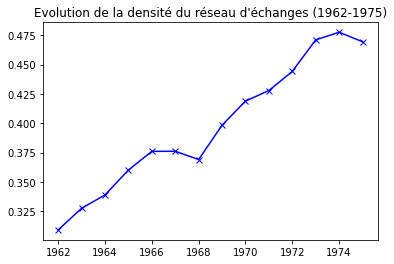

In [30]:
plt.plot(range(1962, 1976), [nx.density(G) for G in liste_networks],  "-xb")
plt.title("Evolution de la densité du réseau d'échanges (1962-1975)")
plt.show()

http://www.cepii.fr/pdf_pub/wp/2013/wp2013-24.pdf

D'après le CEPII (utilisant la base BACI), 


*The trade network is characterized by high dimensionality and strong heterogeneity. The
22002 existing links in 2007 correspond to a density of the network of 0.7 (i.e the ratio between the number of “realized” links and the number of maximum links possible),
indicating that taking two countries at random the probability of an existing trade link
among them is of 70%.*

Même ordre de grandeur ici (https://core.ac.uk/download/pdf/54926841.pdf)


### Diamètre

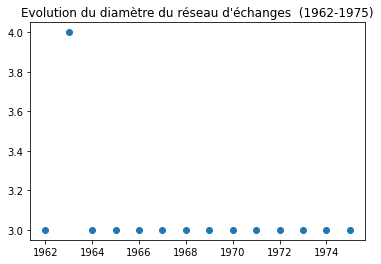

In [31]:
plt.scatter(range(1962, 1976), [nx.diameter(G) for G in liste_networks])
plt.title("Evolution du diamètre du réseau d'échanges  (1962-1975)")
plt.show()

**Résultat en 2013 pour le réseau des échanges de 2009 = 2**: 
    An anatomy of the World Trade Network, William Chow, https://www.hkeconomy.gov.hk/en/pdf/wp/An%20Anatomy%20of%20the%20World%20Trade%20Network%20(July%202013).pdf
    

###  Etude de la distribution du degré

#### Degré moyen

In [32]:
for G in liste_networks:
    print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 156
Number of edges: 3737
Average degree:  47.9103
Name: 
Type: Graph
Number of nodes: 157
Number of edges: 4011
Average degree:  51.0955
Name: 
Type: Graph
Number of nodes: 161
Number of edges: 4365
Average degree:  54.2236
Name: 
Type: Graph
Number of nodes: 161
Number of edges: 4638
Average degree:  57.6149
Name: 
Type: Graph
Number of nodes: 161
Number of edges: 4843
Average degree:  60.1615
Name: 
Type: Graph
Number of nodes: 162
Number of edges: 4905
Average degree:  60.5556
Name: 
Type: Graph
Number of nodes: 164
Number of edges: 4933
Average degree:  60.1585
Name: 
Type: Graph
Number of nodes: 173
Number of edges: 5926
Average degree:  68.5087
Name: 
Type: Graph
Number of nodes: 174
Number of edges: 6304
Average degree:  72.4598
Name: 
Type: Graph
Number of nodes: 175
Number of edges: 6514
Average degree:  74.4457
Name: 
Type: Graph
Number of nodes: 175
Number of edges: 6762
Average degree:  77.2800
Name: 
Type: Graph
Number of nodes: 175
Num

Le degré moyen et le nombre de liens semble augmenter au cours de la période. 

#### Histogramme du degré

In [33]:
#Fonction utilisée précédemment dans les TD pour la représentation en loglog de la distribution du degré. 
def logBinning(degreeList,nbin):
    kmin=min(degreeList)
    kmax=max(degreeList)
    logBins = np.logspace(np.log10(kmin), np.log10(kmax),num=nbin)
    logBinDensity, binedges = np.histogram(degreeList, bins=logBins, density=True)
    logBins = np.delete(logBins, -1)

    return logBinDensity, logBins

0


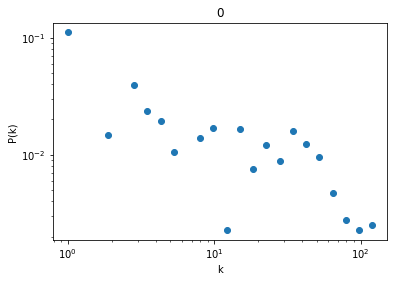

1


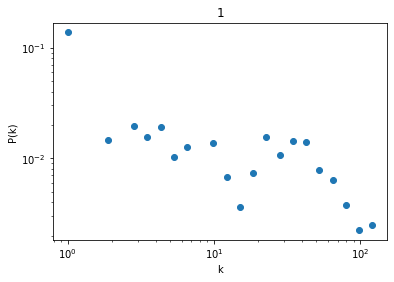

2


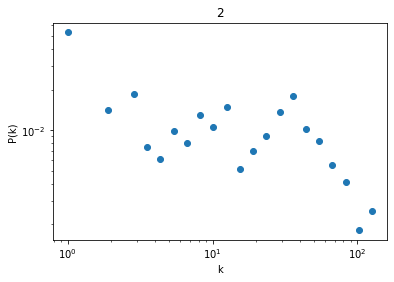

3


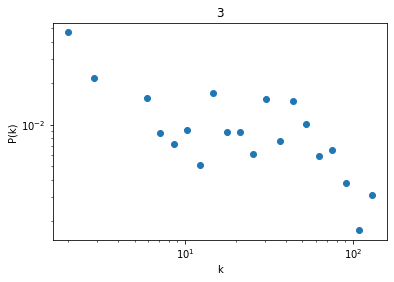

4


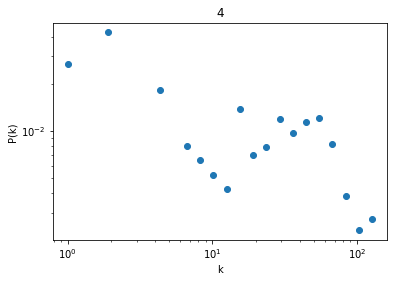

5


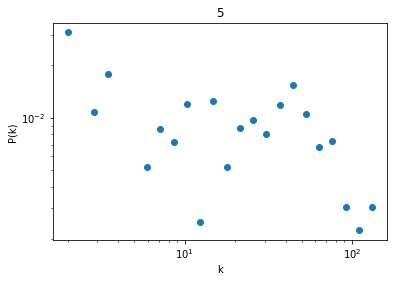

6


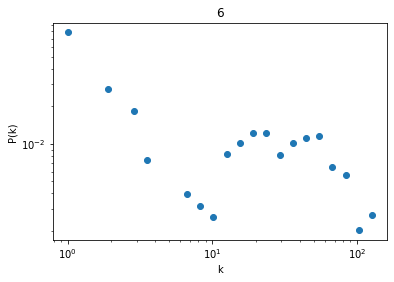

7


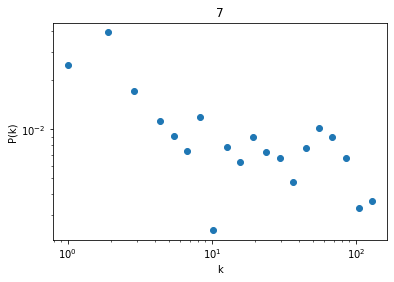

8


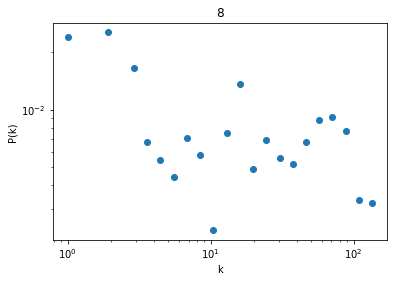

9


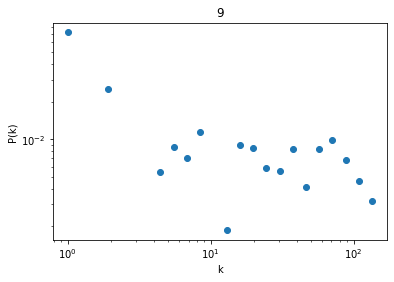

10


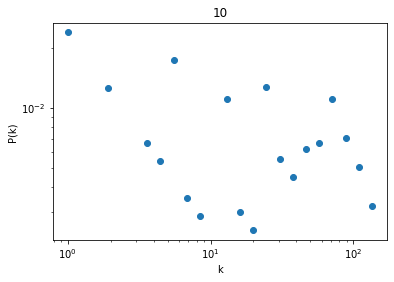

11


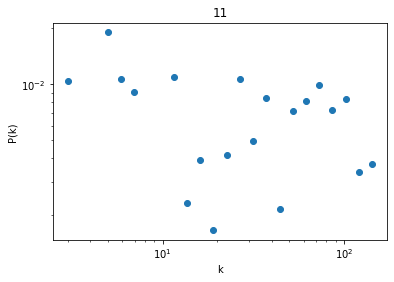

12


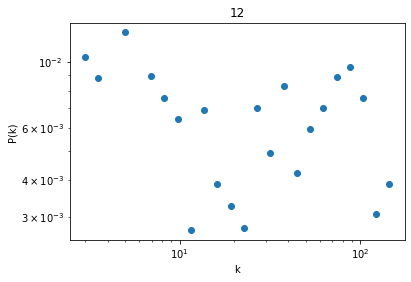

13


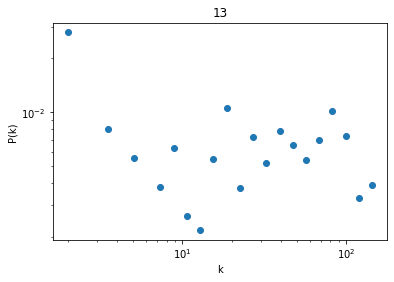

In [34]:
liste_kappa = []
for j in range(len(liste_networks)):
    print(j)
    xx=[ liste_networks[j].degree(i) for i in list(liste_networks[j].nodes())]
    y,x=logBinning(np.array(xx),25)
    plt.loglog(x,y,'o')
    plt.title(str(j))
    plt.xlabel('k')
    plt.ylabel('P(k)')
    liste_kappa.append(np.mean([u**2 for u in xx])/(np.mean(xx))**2)
    plt.show()

L'aspect décroissant de la distribution loglog du degré indique l'hétérogénéité du réseau, même si le nuage de points ne forme pas de ligne claire.

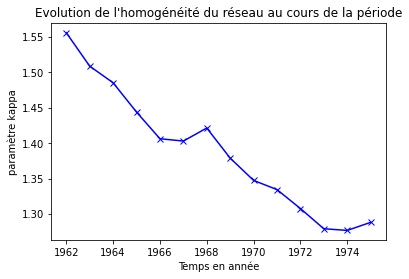

In [36]:
plt.title("Evolution de l'homogénéité du réseau au cours de la période")
plt.plot(range(1962,1976), liste_kappa, "-xb")
plt.xlabel('Temps en année')
plt.ylabel('paramètre kappa')
plt.show()

On constate que pour toute période, l'indicateur d'hétérogénéité $\kappa$ est supérieur à 1. Ce résultat implique que le réseau devient de plus en plus homogène, et qu'il présente de moins en moins de variations autour du degré moyen.

### Mesures faisant intervenir la pondération [Analyse différenciée selon les deux réseaux]

### Coefficient de clustering moyen

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:15<00:00,  1.12s/it]


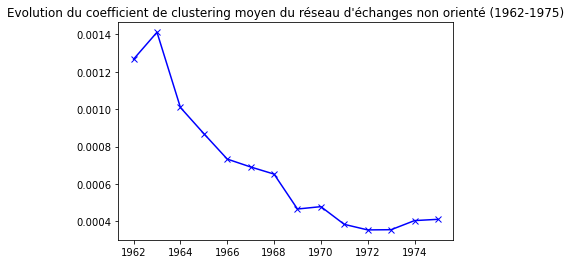

In [37]:
#Réseau non orienté
plt.plot(range(1962, 1976), [nx.average_clustering(G, weight= "FLOW") for G in tqdm.tqdm(liste_networks)],  "-xb")
plt.title("Evolution du coefficient de clustering moyen du réseau d'échanges non orienté (1962-1975)")
plt.xtitle("Temps en année")
plt.show()

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [03:20<00:00, 14.35s/it]


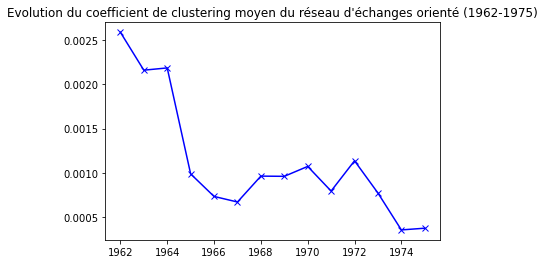

In [38]:
#Réseau orienté
plt.plot(range(1962, 1976), [nx.average_clustering(G, weight= "weight2") for G in tqdm.tqdm(liste_networks_oriented)],  "-xb")
plt.title("Evolution du coefficient de clustering moyen du réseau d'échanges orienté (1962-1975)")
plt.xtitle("Temps en année")
plt.show()

### Average shortest path

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:16<00:00,  1.15s/it]


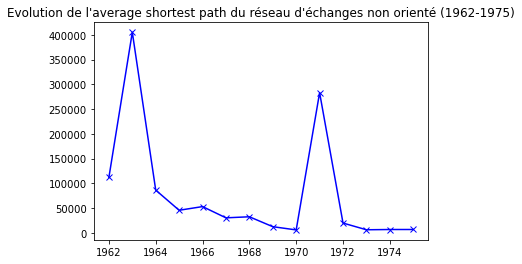

In [39]:
plt.plot(range(1962, 1976), [nx.average_shortest_path_length(G, weight= "FLOW") for G in tqdm.tqdm(liste_networks)], "-xb")
plt.title("Evolution de l'average shortest path du réseau d'échanges non orienté (1962-1975)")
plt.show()

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.34it/s]


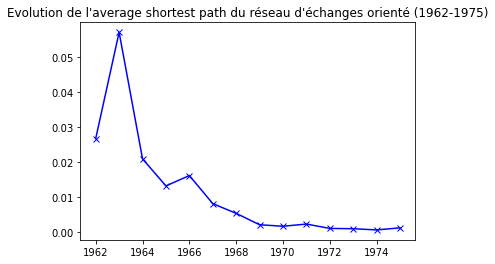

In [40]:
#Ne pas faire tourner car met trop de temps [image enregistrée]
plt.plot(range(1962, 1976), [nx.average_shortest_path_length(G, weight= "weight2") for G in tqdm.tqdm(liste_networks_oriented)],  "-xb")
plt.title("Evolution de l'average shortest path du réseau d'échanges orienté (1962-1975)")
plt.show()

An anatomy of the World Trade Network, William Chow (https://www.hkeconomy.gov.hk/en/pdf/wp/An%20Anatomy%20of%20the%20World%20Trade%20Network%20(July%202013).pdf) reporte un average shortest path de 1.38 pour le réseau de 2009. Dépend du système de pondération. 

Ici, intéressant de voir que le pic en 1971 est complètement lissé par le second système de pondération.


## Mesures de centralité dans le réseau

On cherche ici à observer les points les plus centraux et les moins centraux des réseau, en passant en revue les différentes mesures de centralité. 

In [41]:
i = 1962
for G in liste_networks :
    print(str(i))
    #Degree centrality
    dict_ = nx.degree_centrality(G)
    max_keys = [key for key, value in dict_.items() if value == max(dict_.values())]
    print(['Max degree centrality',max_keys])
    min_keys = [key for key, value in dict_.items() if value == min(dict_.values())]
    print(['Min degree centrality',min_keys])
    
    #Closeness centrality
    dict_ = nx.closeness_centrality(G)
    max_keys = [key for key, value in dict_.items() if value == max(dict_.values())]
    print(['Max closeness centrality',max_keys])
    min_keys = [key for key, value in dict_.items() if value == min(dict_.values())]
    print(['Min closeness centrality',min_keys])
    
    #Betweeness centrality
    dict_ = nx.betweenness_centrality(G)
    max_keys = [key for key, value in dict_.items() if value == max(dict_.values())]
    print(['Max betweenness centrality',max_keys])
    min_keys = [key for key, value in dict_.items() if value == min(dict_.values())]
    print(['Min betweenness centrality',min_keys])
    
    #Eigenvector centrality
    dict_ = nx.eigenvector_centrality(G)
    max_keys = [key for key, value in dict_.items() if value == max(dict_.values())]
    print(['Max eigenvector centrality',max_keys])
    min_keys = [key for key, value in dict_.items() if value == min(dict_.values())]
    print(['Min eigenvector centrality',min_keys])
    
    

    i = i + 1

1962
['Max degree centrality', ['GBR']]
['Min degree centrality', ['FLK', 'MNG', 'PRK', 'STP']]
['Max closeness centrality', ['GBR']]
['Min closeness centrality', ['MNG', 'PRK']]
['Max betweenness centrality', ['GBR']]
['Min betweenness centrality', ['ALB', 'PNG', 'MRT', 'NRU', 'PYF', 'VUT', 'WSM', 'GMB', 'GNB', 'GNQ', 'GUF', 'OMN', 'SPM', 'FRO', 'GRL', 'ARE', 'CPV', 'FLK', 'MAC', 'ZWE', 'MNG', 'PRK', 'STP']]
['Max eigenvector centrality', ['GBR']]
['Min eigenvector centrality', ['MNG', 'PRK']]
1963
['Max degree centrality', ['GBR']]
['Min degree centrality', ['BDI', 'FLK', 'MNG', 'PRK', 'STP']]
['Max closeness centrality', ['GBR']]
['Min closeness centrality', ['BDI']]
['Max betweenness centrality', ['GBR']]
['Min betweenness centrality', ['NRU', 'PNG', 'PYF', 'QAT', 'VUT', 'WSM', 'BDI', 'GNB', 'GNQ', 'OMN', 'GRL', 'MAC', 'FRO', 'ARE', 'CPV', 'FLK', 'MYS', 'ZWE', 'MNG', 'PRK', 'STP']]
['Max eigenvector centrality', ['GBR']]
['Min eigenvector centrality', ['BDI']]
1964
['Max degree cen

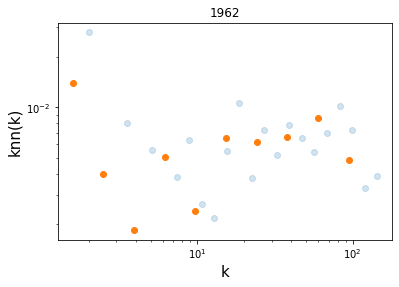

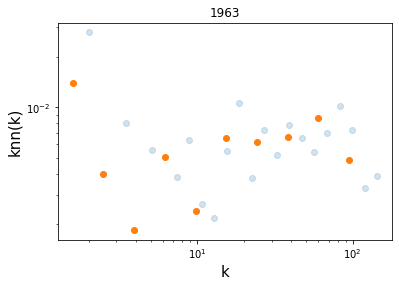

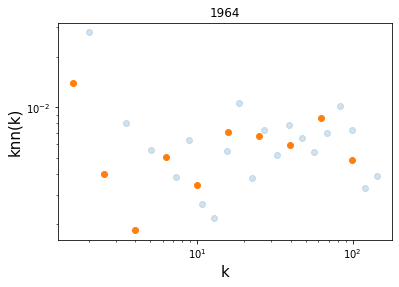

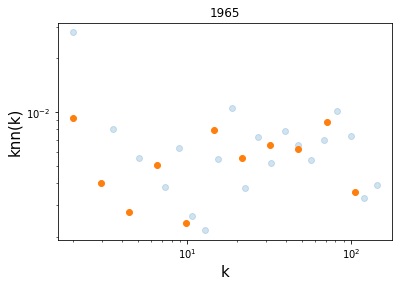

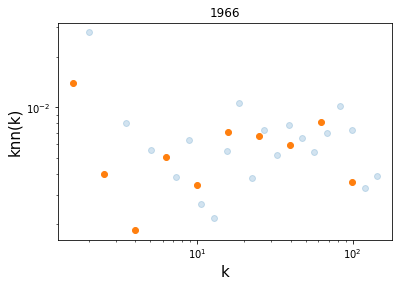

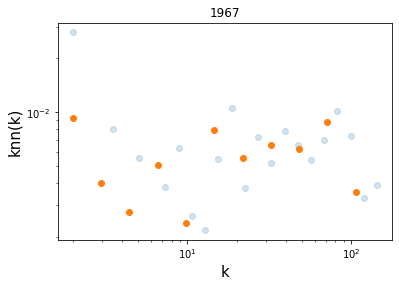

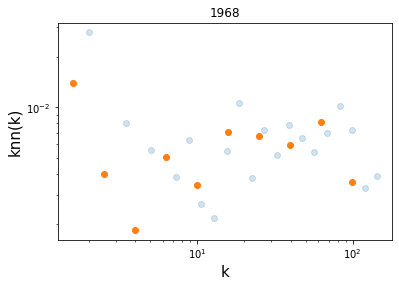

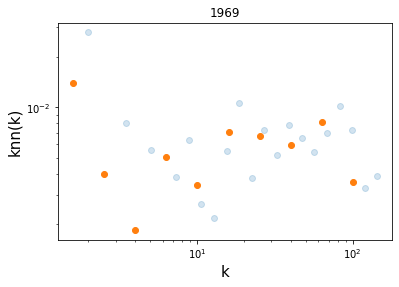

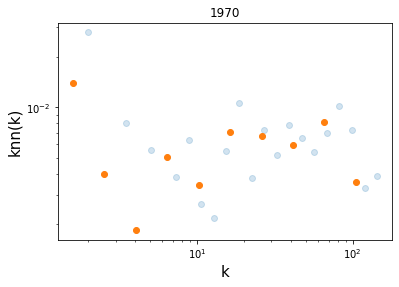

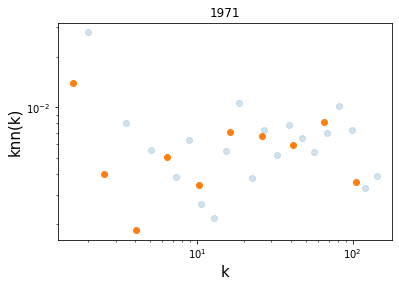

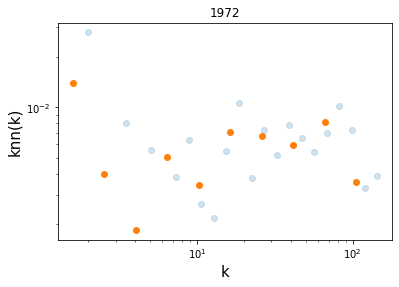

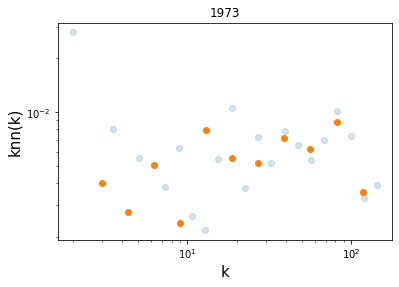

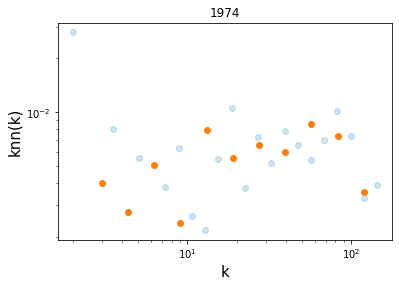

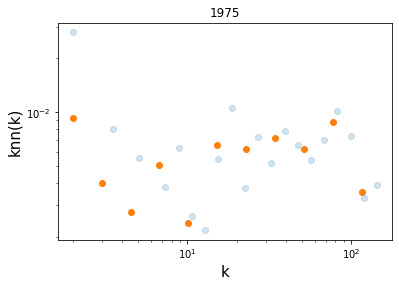

In [42]:
import scipy.stats

def knn(k):
        liste = list(degree_df[degree_df[1] == k][0])
        L = []
        for noeud in liste:
            L.append(knn_i(noeud))
        return(np.mean(L))

i = 1962
for G in liste_networks: 
    degree_df = pd.DataFrame(G.degree())
    kmin=min(degree_df[1])
    kmax=max(degree_df[1])
    logBins = np.logspace(np.log10(kmin), np.log10(kmax), num = 12)

    plt.loglog(x,y,'o',alpha=0.2)
    ybin,xbin,binnumber=scipy.stats.binned_statistic(x,y,statistic='mean',bins=logBins)
    plt.loglog(xbin[:-1],ybin,'o')
    plt.title(str(i))
    plt.xlabel('k',size=15)
    plt.ylabel('knn(k)',size=15)
    plt.show()
    
    i = i + 1

Pour l'ensemble des réseaux, on ne remarque aucune tendance claire = pas d'$assortative$  $mixing$, ou $degree$  $homophily$, ce qui signifie que les noeuds présentant les plus hauts degrées ont tendance à être connectés à d'autres noeuds de haut degrée.

# II - Statistiques descriptives à l'échelles des noeuds

On se concentre sur un sous-ensemble de noeuds, et on cherche à évaluer l'évolution de leur position dans le réseau au cours de la période.

 <span style="color:blue">**Antoine je te laisse compléter la liste des pays qui t'intéressent pour ton mémoire.** </span>

In [43]:
liste_pays = ["FRA", "DZA", "CMR"]

100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 3499.63it/s]

FRA
DZA
CMR


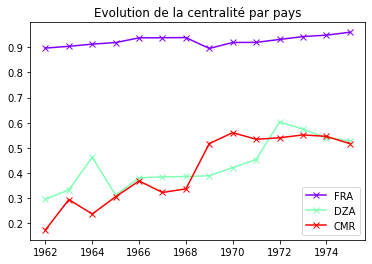

In [44]:
color = plt.cm.rainbow(np.linspace(0, 1, len(liste_pays)))

for i in range(0,len(liste_pays)):
    pays = liste_pays[i]
    col = color[i]
    print(pays)
    plt.plot(range(1962, 1976),[nx.degree_centrality(G)[pays] for G in tqdm.tqdm(liste_networks)] , "-xb", c = col, label = pays)
    plt.title("Evolution de la centralité par pays")
plt.legend()
plt.show()

  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

FRA


  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

DZA


  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

CMR


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:08<00:00,  1.65it/s]


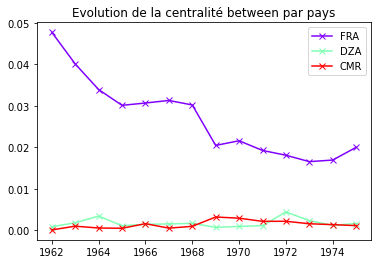

In [45]:
color = plt.cm.rainbow(np.linspace(0, 1, len(liste_pays)))


for i in range(0,len(liste_pays)):
    pays = liste_pays[i]
    col = color[i]
    print(pays)
    plt.plot(range(1962, 1976),[nx.betweenness_centrality(G)[pays] for G in tqdm.tqdm(liste_networks)] , "-xb", c = col, label = pays)
    plt.title("Evolution de la centralité between par pays")
plt.legend()
plt.show()


  7%|█████▉                                                                             | 1/14 [00:00<00:01,  8.93it/s]

FRA


 14%|███████████▊                                                                       | 2/14 [00:00<00:01, 11.40it/s]

DZA


 14%|███████████▊                                                                       | 2/14 [00:00<00:01, 11.01it/s]

CMR


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:02<00:00,  5.55it/s]


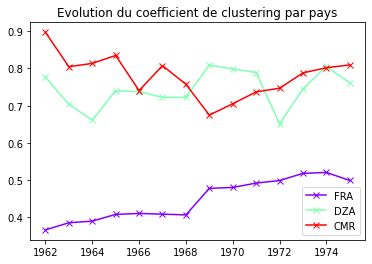

In [46]:
color = plt.cm.rainbow(np.linspace(0, 1, len(liste_pays)))


for i in range(0,len(liste_pays)):
    pays = liste_pays[i]
    col = color[i]
    print(pays)
    plt.plot(range(1962, 1976),[nx.clustering(G)[pays] for G in tqdm.tqdm(liste_networks)] , "-xb", c = col, label = pays)
    plt.title("Evolution du coefficient de clustering par pays")
plt.legend()
plt.show()


# III - Etude des communautés à l'intérieur du réseau

## Etude des cliques

  0%|                                                                                           | 0/14 [01:09<?, ?it/s]


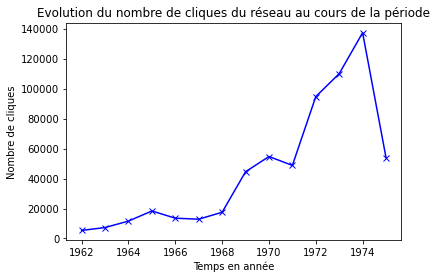

In [53]:
#Rappel : on cherche le nombre de cliques sur un graphe non orienté
plt.title("Evolution du nombre de cliques du réseau au cours de la période")
plt.plot(range(1962,1976),  [len(list(nx.find_cliques(G))) for G in liste_networks], "-xb")
plt.xlabel('Temps en année')
plt.ylabel('Nombre de cliques')
plt.show()

 14%|███████████▊                                                                       | 2/14 [00:00<00:01,  9.71it/s]

FRA


 36%|█████████████████████████████▋                                                     | 5/14 [00:00<00:00, 46.80it/s]

DZA


 57%|███████████████████████████████████████████████▍                                   | 8/14 [00:00<00:00, 44.69it/s]

CMR


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00,  9.74it/s]


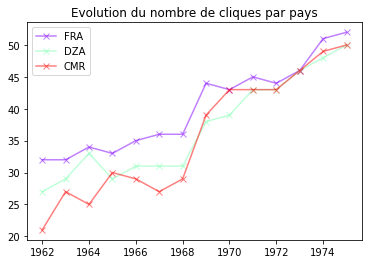

In [55]:
color = plt.cm.rainbow(np.linspace(0, 1, len(liste_pays)))

for i in range(0,len(liste_pays)):
    pays = liste_pays[i]
    col = color[i]
    print(pays)
    plt.plot(range(1962, 1976),[nx.node_clique_number(G, nodes= pays) for G in tqdm.tqdm(liste_networks)] , "-xb", c = col, alpha = 0.5, label = pays)
    plt.title("Evolution du nombre de cliques par pays")
plt.legend()
plt.show()

### Homophilie basée sur les réseaux existants

<span style="color:blue">**Il faut qu'on importe les trucs qu'on veut regarder comme des variables catégorielles au dataframe df, à savoir dans mon souvenir**</span>
    
    - AEF
    - AOF 
    - franc CFA

Ensuite on doit simplement : 
    - convertir df[["iso_o","groupe1", "groupe2", "groupe3"]] en dictionnaires
    
    - Pour chaque network G, utiliser la commande nx.set_node_attributes(G, dictionnaire, "groupe")
    
    - Pour chaque groupe, nx. attribute_assortativity_coefficient (G, category)